In [2]:
import pyswmm
import re
from swmm.toolkit.shared_enum import LinkAttribute,NodeAttribute
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [4]:
 # Replace with appropriate path and filename
directory='/Users/omaraliamer/Desktop/UofT/Publications/Modelling_Draining_in_EPASWMM/QA_Tests_SWMM/'
filename='One_Pipe_PDA3O2S1P_FLOATVALVE.inp'
name_only=filename[0:-4]
print("Selected File: ",name_only)
abs_path=directory+filename

sim=pyswmm.Simulation(inputfile=abs_path, outputfile=directory+name_only+".out")

links=pyswmm.links.Links(sim)   #object containing links in the network model
nodes=pyswmm.nodes.Nodes(sim)


link_flowrates=pd.DataFrame()  #Empty Dataframe to store demand rates
link_volumes=pd.DataFrame()  #Empty Dataframe to store demand rates
node_volumes=pd.DataFrame()

# Reads the output file created above
with pyswmm.Output(directory+name_only+".out") as out:
    # loops through each link in output file
    for link in out.links:
        # Demand Flow Rates to calculate Volume Used by Consumers
        if re.search("^Demand",link):
            link_flowrates.loc[:,link]=out.link_series(link,LinkAttribute.FLOW_RATE).values()
        # Volume in Network Pipes
        elif re.search("^Pipe",link):
            link_volumes.loc[:,link]=out.link_series(link,LinkAttribute.FLOW_VOLUME).values()
    for node in out.nodes:
        # Volume in Consumer Storage Units
        if re.search("^Storage",node) or re.search("^Overflow",node):
            node_volumes.loc[:,node]=out.node_series(node,NodeAttribute.PONDED_VOLUME).values()
        # Volume in Source Reervoir
        elif re.search("^Reservoir",node):
            reservoir=list(out.node_series(node,NodeAttribute.PONDED_VOLUME).values())
    

Selected File:  One_Pipe_PDA3O2S1P_FLOATVALVE

 o  Retrieving project data

In [36]:
brk=0
with pyswmm.Output(directory+name_only+".out") as out:
    for link in out.links:
        time=list(out.link_series(link,LinkAttribute.FLOW_RATE).keys())
        brk=1
        if brk==1:
            break
reporting_step=(time[1]-time[0]).seconds
time = [(x-time[0]).seconds/3600 for x in time]

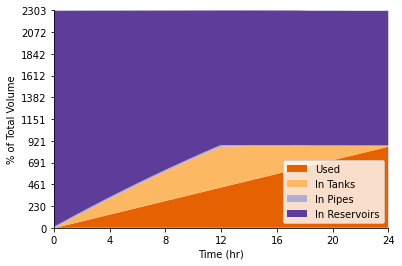

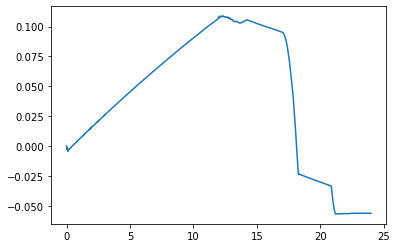

In [38]:
volume_used=(link_flowrates.sum(axis=1)*reporting_step/1000).cumsum()
volume_stored=node_volumes.sum(axis=1)
volume_network=link_volumes.sum(axis=1)
volume_source=reservoir
volume_total=volume_used+volume_network+volume_stored+volume_source
base_volume=volume_total[0]
cont_error=(volume_total-base_volume)/base_volume*100
water_balance=pd.DataFrame(zip(time,volume_source,volume_network,volume_stored,volume_used,volume_total),columns=["Time","Reservoirs","Network","Storage","Used","Total"])

y=np.vstack([water_balance["Used"],water_balance["Storage"],water_balance["Network"],water_balance["Reservoirs"]])
fig, ax=plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(6)
ax.stackplot(water_balance["Time"],y,labels=["Used","In Tanks","In Pipes","In Reservoirs"],colors=["#e66101","#fdb863","#b2abd2","#5e3c99"])
ax.set_xlim(0,24)
ax.set_xlabel("Time (hr)")
ax.set_ylabel("% of Total Volume")
ax.set_xticks(np.arange(0,25,4))
ax.set_yticks(np.arange(0,max(water_balance["Total"])+1,max(water_balance["Total"])/10))
ax.set_ylim(0,max(water_balance["Total"])+1)
ax.legend(loc="lower right")
ax.spines[['right', 'top']].set_visible(False)
plt.show

fig,ax = plt.subplots()
ax.plot(water_balance["Time"],cont_error)

In [3]:
water_balance.to_csv(directory+name_only+"WaterBalance.csv")